# Portuguese Vocabulary Exercises
### Project by Thomas Lindstrom-Vautrin
Learning languages is a hobby of mine. One of the languages I have taken an interest in is Portuguese. As I have been learning, I have tried to find ways to make that learning more effective. My goal with this project is simply to have a place to train on Portuguese vocabulary as I continue to learn the language. The main feature I will implement is a means of extracting relevant vocabulary from Portuguese text copied and pasted from any online source. In particular, when watching a Portuguese language show on Netflix, I want to be able to copy and paste the Portuguese subtitles into this program and extract the most relevant vocabulary terms so that I can anticipate them before watching an episode. But this extends also to news articles I may read in Portuguese, or chapters I read in e-books... Any Portuguese text should work.

## Setting Up
Here we install and import all the necessary packages. We will use the Google Translate package instead of performing our own machine translation, since the main thrust of this project is identifying relevant vocabulary and not translating that vocabulary.

In [16]:
# These modules are part of the Python Standard Library
import glob
import re
from collections import Counter
import random
import pickle

import numpy as np
import pandas as pd

from googletrans import Translator
from IPython.display import clear_output

from scipy.stats import arcsine
from scipy.stats import beta
import matplotlib.pyplot as plt

In preparing for this project, I referenced the following notebook: https://medium.com/dair-ai/neural-machine-translation-with-attention-using-pytorch-a66523f1669f

Some code has been adapted from that notebook, and we use data from the same original source: http://www.manythings.org/anki/

In the following code we import and clean the Portuguese phrases which we use as a basis for our program.

In [17]:
lines = open('data/por.txt', encoding='UTF-8').read().strip().split('\n')

In [18]:
original_phrases = [[p for p in l.split('\t')] for l in lines]

In [19]:
data = pd.DataFrame(original_phrases, columns=["eng", "pt", "other"])
del(data["other"])
print(data.columns)

Index(['eng', 'pt'], dtype='object')


In [20]:
data

,eng,pt
0,Go.,Vai.
1,Go.,Vá.
2,Go.,ir.
3,Hi.,Oi.
4,Run!,Corre!
...,...,...
157970,I recommend contributing sentences in your own...,Eu recomendo contribuir com frases em seu próp...
157971,I recommend contributing sentences in your own...,Recomendo que você contribua com frases em seu...
157972,No matter how much you try to convince people ...,Não importa o quanto você tenta convencer os o...
157973,Some movies make such an impact that one never...,Alguns filmes são tão marcantes que jamais nos...


In [21]:
# Transform a sentence into a string of space-separated words without punctuation.
def words_only(w):
    # These characters have been identified as the Portuguese-language word-forming characters in our dataset.
    w = re.sub(r"[^oeasrmiuntdclpvqThãfEgêbáézVOjNAçMóPxQíySCDàIFBÉúHJôGUõLâkRwKÀYÁWXÍZÓÂ]+", " ", w)
    
    w = w.strip()
    
    return w

# Transform a sentence into a string of space-separated words with space-separated "final punctuation".
def final_punctuation(w):
    # Add a space before and after "final punctuation".
    # "Final punctuation" is defined as punctuation which either ends a sentence or begins a quotation.
    # In either of these cases the following character is likely to be capitalized even if the word is not
    # a named entity, which is relevant for rudimentary identification of named entities.
    w = re.sub(r'([?.!\'"])', r" \1 ", w)
    w = re.sub(r'[ ]+', " ", w)
    
    w = re.sub(r'[^oeasrmiuntdclpvqThãfEgêbáézVOjNAçMóPxQíySCDàIFBÉúHJôGUõLâkRwKÀYÁWXÍZÓÂ?.!\'"]+', " ", w)
    
    w = w.strip()
    
    return w

# Extracted from "NMT in PyTorch" tutorial.
# https://medium.com/dair-ai/neural-machine-translation-with-attention-using-pytorch-a66523f1669f
def preprocess_sentence(w, context=1):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r'([?.!,])', r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except the existing acceptable characters and ".", "?", "!", ","
    w = re.sub(r"[^oeasrmiuntdclpvqThãfEgêbáézVOjNAçMóPxQíySCDàIFBÉúHJôGUõLâkRwKÀYÁWXÍZÓÂ?.!,]+", " ", w)
    
    w = w.strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    for i in range(context):
        w = '<start> ' + w + ' <end>'
    return w

## Rudimentary Named Entity Recognition
It will be useful to identify words which are named entities and do not constitute typical words in the vocabulary. We will use the simple heuristic that a word which is capitalized in the middle of a sentence is most likely a named entity.

In [22]:
# A rudimentary approach to named entity recognition:
# Identify non-lowercase words in parts of the phrase which are not the beginning of the sentence
# or after "final punctuation".

fin_punct = ['?', '.', '!', "'", '"']

# Identify all words in the corpus, including different capitalizations.
all_words = set()
for phrase in data["pt"]:
    all_words.update(words_only(phrase).split(' '))

# Perform a rudimentary form of named entity recognition.
# Identify capitalized words which are not at the beginning of a sentence.
def rudimentary_NER(phrases=data["pt"], vocab=all_words):
    named_entities = set()

    for phrase in phrases:
        phrase_words = words_only(phrase).split(' ')
        phrase = final_punctuation(phrase).split(' ')
        for i in range(len(phrase)):
            # If the word is indeed a word and not punctuation and if the word is not all lowercase...
            if phrase[i] not in fin_punct and phrase[i] != phrase[i].lower():
                # If the word is not the first word and does not follow "final punctuation"...
                if phrase[i] != phrase_words[0] and phrase[i-1] not in fin_punct:
                        named_entities.add(phrase[i]) # This is a named entity.
                # If it does have an excuse to be capitalized...
                else:
                    # Check if it has an all lowercase form in the vocabulary...
                    if phrase[i].lower() not in all_words:
                        named_entities.add(phrase[i])
    
    return named_entities

named_entities = rudimentary_NER()

In [23]:
# Remove the two most obvious incorrectly identified named entities
named_entities.remove('A') # feminine equivalent of "the"
named_entities.remove('O') # masculine equivalent of "the"

Now we proceed to create a list of vocabulary extracted from the phrases.

In [24]:
count = Counter()

# Get the counts for each word, treating named entities seperately.
# We do not remove named entities so that they can still be used in sentence production.
for phrase in data["pt"]:
    for word in words_only(phrase).split(' '):
        if word in named_entities:
            count[word] += 1
        else:
            count[word.lower()] += 1

# Define the vocabulary as the words ordered by count. Keep track of these counts also.
vocab = [w for w, c in sorted(count.items(), key=lambda x: x[1], reverse=True)]
count = [c for w, c in sorted(count.items(), key=lambda x: x[1], reverse=True)]

# Get the frequencies from the counts.       
total_count = sum(count)
freq = [c/total_count for c in count]

# Identify the indices of the named entities. We don't need to know which is which.
named_entity_indices = set()
for index, word in enumerate(vocab):
    if word in named_entities:
        named_entity_indices.add(index)    

Here we match each word to the phrases containing it. The following code is commented out because it only needs to be performed once. We then proceed to save the data, and then reload it since it takes some time to generate this data.

In [25]:
# For each word, get all the phrases which contain it.
# phrase_words = [[word if word in named_entities else word.lower() for word in words_only(phrase).split(' ')] for phrase in data["pt"]]
# words_to_phrases = {}
# for i in range(len(phrase_words)):
#     for word in phrase_words[i]:
#         if word in words_to_phrases.keys():
#             words_to_phrases[word].append(data["pt"][i])
#         else:
#             words_to_phrases[word] = [data["pt"][i]]

In [26]:
# pickle_out = open("words_to_phrases.pickle", "wb")
# pickle.dump(words_to_phrases, pickle_out)
# pickle_out.close()

In [27]:
pickle_in = open("words_to_phrases.pickle", "rb")
words_to_phrases = pickle.load(pickle_in)
words_to_phrases['vai']

['Vai.',
 'Vai-te embora!',
 'Vai para dentro.',
 'Como vai o Tom?',
 'Tom vai.',
 'A gente vai tentar.',
 'Quem vai?',
 'Como vai o Tom?',
 'Isso vai funcionar.',
 'Vai funcionar.',
 'Isso vai servir.',
 'Tom vai chorar.',
 'Tom vai morrer.',
 'Vai encontrar Tom.',
 'Vai achar o Tom.',
 'Vai para casa agora.',
 'Vai por ali.',
 'Como vai?',
 'Como vai você?',
 'Vai ficar tudo bem.',
 'Tom vai vir.',
 'Tom vai saber.',
 'Tom vai perder.',
 'Tom vai ficar.',
 'Tom vai falar.',
 'Tom vai esperar.',
 'A gente vai compartilhar.',
 'Quem vai cozinhar?',
 'Ele vai morrer?',
 'Você vai?',
 'Você vai perder.',
 'Vai à escola.',
 'Ele vai caminhar.',
 'Como vai a escola?',
 'Vai queimar.',
 'Isso vai queimar.',
 'Vai funcionar.',
 'Isso vai acontecer.',
 'Isso vai ajudar.',
 'Isso vai ajudar.',
 'Isso vai funcionar.',
 'Tom vai chorar.',
 'Tom vai morrer.',
 'Tom vai pagar.',
 'Tom vai tentar.',
 'Tom vai vencer.',
 'Tom vai falar.',
 'Quem vai pagar?',
 'Quem vai ganhar?',
 'Quem vai dirigir?'

We use the LanguageIndex framework from the NMT in PyTorch tutorial as a useful means of interacting with our vocabulary.

In [28]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  
    def __init__(self, lang):
        """ lang are the list of phrases from each language"""
        # Store the input list of phrases
        self.lang = lang
        # Store a dictionary with word keys and index values
        self.word2idx = {}
        # Store a dictionary with index keys and word values
        self.idx2word = {}
        
        # Store a placeholder for the language vocabulary
        self.vocab = set()
        
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            # update with individual tokens
            self.vocab.update(phrase)
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
            
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

## Storing a User's Vocabulary Knowledge
We want to maintain a database representing how familiar a given user is with a given word. Let us say that a user can be completely unfamiliar with a word, let's say 0% familiar, or completely familiar with a word, let's say 100% familiar. Let us also assume that the average user will be more familiar with more frequent words. In the following "scale_frequency" function, we define a method of transforming the frequency of each word into a level of familiarity with each word.

In [29]:
# Define a scaled frequency which represents the familiarity of the user with each word as a percentage.
def scale_frequency(freq=freq, n=None, level="functional"):
    num = 1
    if not n:
        # Beginner: first 100 words have minimum 50% familiarity
        if level == "beginner":
            num = 100
        # Functional: first 500 words have minimum 50% familiarity 
        elif level == "functional":
            num = 500
        # Conversational: first 1000 words have minimum 50% familiarity
        elif level == "conversational":
            num = 1000
        # Advanced: first 4000 words have minimum 50% familiarity
        elif level == "advanced":
            num = 4000
        # Fluent: first 10000 words have minimum 50% familiarity
        elif level == "fluent":
            num = 10000
    else:
        num = n
        
    # This scales the whole list so that the num-th word has probability 0.5.
    # Tanh behaves in such a way that numbers in [0,1] stay more or less themselves,
    # whereas numbers much larger than zero are squashed into the interval [0,1].
    return np.tanh((0.5/freq[num-1])*np.array(freq)).tolist()

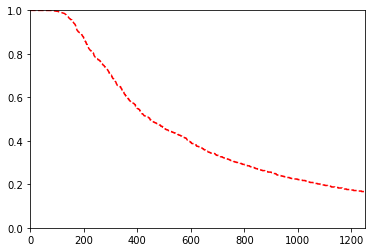

In [30]:
# Visualize probability distribution
x = np.linspace(0, len(vocab), len(vocab))
y = scale_frequency()

plt.ylim(top=max(y), bottom=0)
plt.xlim(left=0, right=1.25*1000)
plt.plot(x, y, "r--")

In the following cells, we manage the data stored for different users of the program.

In [31]:
def initialize_users():
    users = {}
    users["Default"] = scale_frequency()
    pickle_out = open("users.pickle", "wb")
    pickle.dump(users, pickle_out)
    pickle_out.close()

In [32]:
pickle_in = open("users.pickle", "rb")
users = pickle.load(pickle_in)
current_user = "Default"

def set_user(user):
    global current_user
    if user in users.keys():
        current_user = user
        return True
    ret
def get_user():
    return current_user
    
def new_user(user, distr=freq, n=None, level="functional"):
    global users
    global current_user
    if user not in users.keys():
        current_user = user
        users[current_user] = scale_frequency(freq=distr, n=n, level=level)
        
        # Save changes.
        pickle_out = open("users.pickle", "wb")
        pickle.dump(users, pickle_out)
        pickle_out.close()

        # Update local version of snippets.
        pickle_in = open("users.pickle", "rb")
        users = pickle.load(pickle_in)
        
        return True
    return False
        
    
def reset_user(user, distr=freq, n=None, level="functional"):
    global users
    global current_user
    
    if user in users.keys():
        current_user = user
        users[current_user] = scale_frequency(freq=distr, n=n, level=level)
        
        # Save changes.
        pickle_out = open("users.pickle", "wb")
        pickle.dump(users, pickle_out)
        pickle_out.close()

        # Update local version of snippets.
        pickle_in = open("users.pickle", "rb")
        users = pickle.load(pickle_in)
        
        return True
    return False

## Managing Exercise Difficulty
In order to control the difficulty of the exercises presented to the user, we will choose words with different levels of familiarity with different probabilities. In other words, at a medium difficulty level, we want to focus on 50% familiarity words, so that high familiarity and low familiarity words are less likely to show up than words of moderate familiarity, words which are at the cusp of being known. We use a beta distribution over [0,1] to get this effect.

In [33]:
def get_distribution(arr, m=0.5, inv_v=0.05, flatness=0.01):
    if flatness >= 1:
        return np.ones(len(arr)).tolist()
        
    a = m/inv_v; b = (1 - m)/inv_v
    distr = beta.pdf(arr, a, b)
    
    if flatness <= 0:
        return distr
    
    upper = max(distr)
    integral = sum(distr)
    baseline = (upper/((1/flatness)-1))*np.ones(len(arr))
    new_integral = integral + sum(baseline)
    return (distr + baseline)*(integral/new_integral)

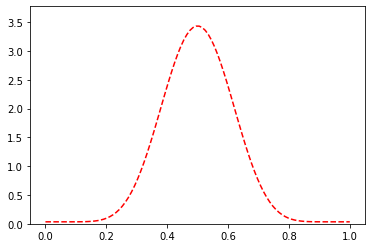

In [34]:
# Visualize probability distribution
x = np.linspace(0, 1.0, 100)
y = get_distribution(x)

plt.ylim(top=1.1*max(y), bottom=0)
plt.plot(x, y, "r--")

## Updating Knowledge
Every time an exercise is undertaken, we need to increase the familiarity of a word which is correctly identified, and decrease the familiarity of a word which is incorrectly identified.

In [35]:
# lr = learning rate; fr = forgetting rate
def update(arr, index, correct, lr=0.3, fr=0.3):
    if correct:
        # Increase its probability
        arr[index] += (1-arr[index])*lr
    else:
        # Decrease its probability
        arr[index] -= arr[index]*fr

## Managing Snippets of Input Text
We save copied-and-pasted snippets of Portuguese text in bag-of-words form.

In [36]:
# This converts a piece of (mostly) Portuguese text into what is essentially a bag of words interpretation.
# We keep a dictionary of the (previously known, non-named-entity) words and their counts in the text.
def convert_snippet(input):
    # Exclude local named entities.
    ne = rudimentary_NER(phrases=[input])
    local_count = Counter()
    
    for w in words_only(input).split(' '):
        if w not in ne:
            if w.lower() in vocab:
                local_count[vocab.index(w.lower())] += 1
    
    return local_count   

In [37]:
# This is a method for initializing the first snippets data structure, where we save the count profiles
# of snippets of text which have been saved to serve as a basis for training exercises.
def initialize_snippets():
    snippets = {}
    pickle_out = open("snippets.pickle", "wb")
    pickle.dump(snippets, pickle_out)
    pickle_out.close()

In [38]:
pickle_in = open("snippets.pickle", "rb")
snippets = pickle.load(pickle_in)

def save_snippet(input, title=None):
    # Bring in saved snippets.
    global snippets
    
    # Configure default titles.
    if not title:
        title = "snippet" + str(len(snippets.keys()))
    if title in snippets.keys():
        title = title + str(len(snippets.keys()))
        
    local_count = convert_snippet(input)
    
    # Update snippets.
    snippets[title] = dict(local_count)
    
    # Save changes.
    pickle_out = open("snippets.pickle", "wb")
    pickle.dump(snippets, pickle_out)
    pickle_out.close()
    
    # Update local version of snippets.
    pickle_in = open("snippets.pickle", "rb")
    snippets = pickle.load(pickle_in)
    return title

## Identifying the Local Importance of Words in a Snippet of Text
Here we identify which words are most important to the text, as well as which words are least familiar to the user.

In [39]:
def local_indices(input, user=current_user):
    # Get the indices in order from largest to smallest local count in the document.
    indices = [i for i, c in sorted(input.items(), key=lambda x: x[1], reverse=True)]
    return indices


def local_frequency(input, user=current_user): 
    local_count = [c for i, c in sorted(input.items(), key=lambda x: x[1], reverse=True)]
    tot = sum(local_count)
    
    # Return the frequency of each local word with respect to the local document.
    local_freq = [c/tot for c in local_count]

    return local_freq


def local_importance(input, user=current_user):    
    indices = local_indices(input, user)
    local_freq = local_frequency(input, user)
    
    # Importance is the ratio of the local frequency to the global frequency.
    importance = [local_freq[i]/freq[indices[i]] for i in range(len(indices))]
    by_importance = [ind for imp, ind in sorted(zip(importance, indices))]
    # Rank the words locally by their importance in the document.
    importance_rank = [by_importance.index(i)+1 for i in indices]
    
    return importance, importance_rank


def local_familiarity(input, user=current_user):
    indices = local_indices(input, user)
    
    # Each user's associated list is a list of that user's familiarity with each word in the vocabulary.
    familiarity = [users[user][indices[i]] for i in range(len(indices))]
    by_familiarity = [i for f, i in sorted(zip(familiarity, indices))]
    # Rank the words locally by their familiarity.
    familiarity_rank = [by_familiarity.index(i)+1 for i in indices]
    
    return familiarity, familiarity_rank


def local_interest(input, user=current_user):
    indices = local_indices(input, user)
    
    # Importance is the ratio of the local importance to the global importance.
    importance, importance_rank = local_importance(input, user)
    
    # Each user's associated list is a list of that user's familiarity with each word in the vocabulary.
    familiarity, familiarity_rank = local_familiarity(input, user)
    
    # A word is more interesting to a user if it has a higher importance and a lower familiarity.
    # Using the ranks avoids divisions by zero and also puts importance and familiarity on a similar scale.
    interest = [importance_rank[i]/familiarity_rank[i] for i in range(len(indices))]
    by_interest = [ind for inr, ind in sorted(zip(interest, indices))]
    # Rank the words locally by their interest.
    interest_rank = [by_interest.index(i)+1 for i in indices]
    
    return interest, interest_rank


def words_of_interest(input, user=current_user):
    # Rank the words in reverse order according to their interest.
    indices = local_indices(input, user)
    interest, interest_rank = local_interest(input, user)
    
    words_by_interest = [-1 for i in range(len(indices))]
    for i in range(len(indices)):
        words_by_interest[-interest_rank[i]] = indices[i]
    
    return words_by_interest


def frequency_weighted_familiarity(input, user=current_user):
    indices = local_indices(input, user)
    
    frequency = [freq[indices[i]] for i in range(len(indices))]
    # Each user's associated list is a list of that user's familiarity with each word in the vocabulary.
    familiarity, familiarity_rank = local_familiarity(input, user)
    
    # Here we weight the familiarity by the relative importance of the word to the text.
    total_freq = sum(frequency)
    fwf = [(frequency[i]/total_freq)*familiarity[i] for i in range(len(indices))]
    by_fwf = [ix for fr, ix in sorted(zip(fwf, indices))]
    # Rank the words locally by their interest.
    fwf_rank = [by_fwf.index(i)+1 for i in indices]
    
    return fwf, fwf_rank

In [40]:
def most_familiar_sentence(word):
    if word in vocab:
        return sorted(zip([sum(frequency_weighted_familiarity(convert_snippet(phrase))[0]) for phrase in words_to_phrases[word]], words_to_phrases[word]), reverse=True)[0][1]
    return "No example sentence exists."

## Interface
In the following cells we create the simple terminal interface to run exercises based on both snippets of Portuguese text extracted from the internet and our existing knowledge.

In [41]:
# fuzzy focus = 0.25, normal focus = 0.05, sharp focus = 0.005, laser focus = 0.0005.
# Easy = 0.75, Medium = 0.5, Hard = 0.25. (Or adjust range between .25 and .75.)
# Smoothness ranges between 0 and 1

def single_exercise(exercise_words=range(len(vocab)), avoid_list=[], user=current_user, mean=0.5, focus_width=0.05, flatness=0.01):
    words = []
    distr = get_distribution(users[user], m=mean, inv_v=focus_width, flatness=flatness)

    words.append(random.choices([i for i in exercise_words if i not in avoid_list and i not in named_entity_indices],
                   [distr[i] for i in exercise_words if i not in avoid_list and i not in named_entity_indices])[0])

    for i in range(3):
        words.append(random.choice([i for i in range(len(vocab)) if i not in words and i not in named_entity_indices]))

    indices = list(range(4))
    random.shuffle(indices)

    trans = Translator()

    options = [char for char in'ABCD']
    output = [vocab[words[i]] for i in indices]
    english_output = []

    for i in range(4):
        t = trans.translate(output[i], src='pt', dest='en')
        english_output.append(t.text)

    print('Select the correct translation for:\n\n"' + vocab[words[0]] +
          '" (Your familiarity with this word is {}%.)\n'.format(round(100*users[user][words[0]])))
    print('Example sentence: ' + most_familiar_sentence(vocab[words[0]]) + "\n")
    for i in range(4):
        print(options[i] + ") " + english_output[i])
    print("")
    print("Return on empty to quit.")
    print("")
    answer = input()
    if answer == "":
        return None
    while answer not in options:
        print('\nPlease enter "A", "B", "C", or "D".\n')
        answer = input()
    
    correct = indices[options.index(answer)] == 0
    if correct:
        print("\nNice job, {}!\n".format(user))
    else:
        print("\nSorry, {}. The correct answer was {}.\nBetter luck next time!\n".format(user, options[indices.index(0)]))
    update(users[user], words[0], correct)
    
    return words[0]

In [42]:
def multi_session(exercise_words=range(len(vocab)), reps=20, user=current_user, mean=0.5, focus_width=0.05, flatness=0.01):
    
    print("\nHello, {}!\n".format(user))
    count = 0
    avoid_list = []
    for i in range(reps):
        print("-----------")
        print("Problem #{}".format(i+1))
        print("-----------")
        avoid = single_exercise(exercise_words=exercise_words, avoid_list=avoid_list, user=user, mean=mean, focus_width=focus_width, flatness=flatness)
        if avoid:
            avoid_list.append(avoid)
        else:
            break
        count+=1
    if count > 1:
        print("\n{} Exercises Complete!".format(count))
    if count == 1:
        print("1 Exercise Complete!")

In [43]:
levels = ["beginner", "functional", "conversational", "advanced", "fluent"]

def user_interface():
    global users
    global current_user
    print("\n\nMANAGE USERS")
    print("\nCurrent user: " + current_user)
    print("\nSelect from the following options:\n")
    print("A) Change user")
    print("B) Add user")
    print("C) Delete user")
    print("D) Cancel")
    choice = input()
    while choice not in [char for char in "ABCD"]:
            print('\nPlease enter "A", "B", "C", or "D".\n')
            choice = input()
    if choice == "A":
        print("\n\nCHANGE USER")
        print("\nCurrent user: " + current_user)
        print("\n\nHere are the existing users:\n")
        for user in users.keys():
            print("\t" + user)
        print("\nPlease enter your username (or return empty to cancel):")
        user = input()
        if user != "":
            while user not in users.keys():
                if user != "":
                    print("This user does not exist. Enter an existing username:")
                    user = input()
                else:
                    print("Canceled.")
                    break
            if user != "":
                set_user(user)
            else:
                print("Canceled.")
        else:
            print("Canceled.")
            
    if choice == "B":
        print("\n\nADD USER")
        print("\nCurrent user: " + current_user)
        print("\n\nHere are the existing users:\n")
        for user in users.keys():
            print("\t" + user)
        print("\nPlease enter a new username (or return empty to cancel):")
        user = input()
        while user in users.keys():
            print("This is an existing user. Enter a new username:")
            user = input()
        if user != "":            
            print("Choose your current Portuguese level from:\n")
            for level in levels:
                print("\t" + level)
            print("")
            print("Or enter the rough number of words you are familiar with.")
            print("Type 'Default' for default parameters.")
            print("Return empty to cancel.")
            inp = input()
            if inp == 'Default':
                new_user(user)
                print("New user '{}'.".format(user))
            elif inp != "":
                try:
                    val = int(inp)
                    new_user(user, n=inp)
                    print("New user '{}'.".format(user))
                except ValueError:
                    if inp in levels:
                        new_user(user, level=inp)
                        print("New user '{}'.".format(user))
        else:
            print("Canceled.")
    if choice == "C":
        print("\n\nDELETE USER")
        print("\nCurrent user: " + current_user)
        print("\n\nHere are the existing users:\n")
        for user in users.keys():
            print("\t" + user)
        print("\nPlease enter username to delete (or return empty to cancel):")
        user = input()
        while user != "":
            if user in users.keys():
                del users[user]
                if user == current_user: 
                    set_user("Default")
                print("Deleted '{}'.".format(user))
            else:
                print("No user deleted. User does not exist.")
            print("\n\nDELETE USER")
            print("\nCurrent user: " + current_user)
            print("\n\nHere are the existing users:\n")
            for user in users.keys():
                print("\t" + user)
            print("\nPlease enter username to delete (or return empty to cancel):")
            user = input()
        else:
            print("Canceled.")

In [44]:
# fuzzy focus = 0.25, normal focus = 0.05, sharp focus = 0.005, laser focus = 0.0005.
# Easy = 0.75, Medium = 0.5, Hard = 0.25. (Or adjust range between .25 and .75.)
# Smoothness ranges between 0 and 1
focus = {"fuzzy focus": 0.25, "normal focus": 0.05, "sharp focus": 0.005, "laser focus": 0.0005}
difficulty = {"easy": 0.75, "medium": 0.5, "hard": 0.25}

current_reps = 20
current_focus = "normal focus"
current_difficulty = "medium"
current_smoothness = 0.01

def train_interface():
    print("\n\nTRAIN")
    print("\nCurrent user: " + current_user)
    print("\nSelect from the following options:\n")
    print("A) Train on existing knowledge")
    print("B) Train on existing snippet")
    print("C) Train on new snippet")
    print("D) Update parameters")
    print("E) Cancel")
    choice = input()
    while choice not in [char for char in "ABCDE"]:
        print('\nPlease enter "A", "B", "C", "D", or "E".\n')
        choice = input()
    if choice == "A":
        multi_session(reps=current_reps, user=current_user, mean=difficulty[current_difficulty], focus_width=focus[current_focus], flatness=current_smoothness)
        train_interface()
    if choice == "B":
        train_existing_snippets()
    if choice == "C":
        train_new_snippet()
    if choice == "D":
        update_parameters()
        
def update_parameters():
    global current_reps
    global current_focus
    global current_difficulty
    global current_smoothness
    print("\n\nUPDATE PARAMETERS")
    print("\nCurrent user: " + current_user)
    print("The current parameters are: \n")
    print("Reps: {}".format(current_reps))
    print("Focus: {}".format(current_focus))
    print("Difficulty: {}".format(current_difficulty))
    print("Smoothness: {}".format(current_smoothness))
    print("(Smoothness is on the interval [0,1], where 1 is fully smoothed and 0 is unsmoothed.)")
    print("\nSelect from the following options:\n")
    print("A) Reps")
    print("B) Focus")
    print("C) Difficulty")
    print("D) Smoothness")
    print("E) Cancel")
    choice = input()
    while choice not in [char for char in "ABCDE"]:
        print('\nPlease enter "A", "B", "C", "D", or "E".\n')
        choice = input()
    if choice == "A":
        print("Enter an integer number of reps:")
        inp = input()
        try:
            val = int(inp)
            if val > 0:
                current_reps = val
            else:
                current_reps = 0
        except (ValueError, TypeError):
            print("Woops! That wasn't an integer!")
        update_parameters()
    if choice == "B":
        print("Enter 'fuzzy focus', 'normal focus', 'sharp focus', or 'laser focus':")
        inp = input()
        if inp in focus.keys():
            current_focus = inp
        else:
            print("Woops! That wasn't an option!")
        update_parameters()
    if choice == "C":
        print("Enter 'easy', 'medium', or 'hard':")
        inp = input()
        if inp in difficulty.keys():
            current_difficulty = inp
        else:
            print("Woops! That wasn't an option!")
        update_parameters()
    if choice == "D":
        print("Enter a probability between 0 and 1 (inclusive):")
        inp = input()
        try:
            val = float(inp)
            if val > 1:
                current_smoothness = 1
            elif val < 0:
                current_smoothness = 0
            else:
                current_smoothness = val
        except (ValueError, TypeError):
            print("Woops! That wasn't a probability!")
        update_parameters()
    if choice == "E":
        train_interface()
        
def train_existing_snippets():
    print("\n\nTRAIN SNIPPETS")
    print("\nCurrent user: " + current_user)
    print("\n\nHere are the existing snippets:\n")
    for snippet in snippets.keys():
        print("\t" + snippet)
    print("\nPlease select a snippet:")
    snippet_name = input()
    if snippet_name in snippets.keys():
        ex_words = words_of_interest(snippets[snippet_name])
        ex_words = ex_words[:min(current_reps,len(ex_words))]
        multi_session(exercise_words=ex_words, reps=len(ex_words))
        train_interface()
    else:
        print("Woops! That wasn't an existing snippet!")
        train_existing_snippets()

def train_new_snippet():
    print("\n\nTRAIN NEW SNIPPET")
    print("\nCurrent user: " + current_user)
    print("\n Please enter your new snippet:")
    snippet = input()
    if snippet != "":
        print("\n Please enter your new snippet name:")
        snippet_name = input()
        if snippet_name == "":
            title = save_snippet(snippet)
        else:
            title = save_snippet(snippet, snippet_name)
        print("\nSaved as '{}'".format(title))
        ex_words = words_of_interest(snippets[title])
        ex_words = ex_words[:min(current_reps,len(ex_words))]
        multi_session(exercise_words=ex_words, reps=len(ex_words))
        train_interface()
    else:
        train_interface()

In [45]:
def snippet_interface():
    global snippets
    print("\n\nMANAGE SNIPPETS")
    print("\nCurrent user: " + current_user)
    print("\nSelect from the following options:\n")
    print("A) Add snippet")
    print("B) Delete snippet")
    print("C) Cancel")
    choice = input()
    while choice not in [char for char in "ABC"]:
            print('\nPlease enter "A", "B", or "C".\n')
            choice = input()
    if choice == "A":
        print("\n\nADD SNIPPET")
        print("\nCurrent user: " + current_user)
        print("\n\nHere are the existing snippets:\n")
        for snippet in snippets.keys():
            print("\t" + snippet)
        print("\nPlease enter your new snippet (or return empty to cancel):")
        snippet = input()
        if snippet != "":
            print("\n Please enter your new snippet name:")
            snippet_name = input()
            if snippet_name == "":
                title = save_snippet(snippet)
            else:
                title = save_snippet(snippet, snippet_name)
            print("\nSaved as '{}'".format(title))
        else:
            print("Canceled.")
    if choice == "B":
        print("\n\nDELETE SNIPPET")
        print("\nCurrent user: " + current_user)
        print("\n\nHere are the existing snippets:\n")
        for snippet in snippets.keys():
            print("\t" + snippet)
        print("\nPlease enter a snippet to delete (or return empty to cancel):")
        snippet_name = input()
        if snippet_name != "":
            if snippet_name in snippets.keys():
                del snippets[snippet_name]
                print("Deleted '{}.'".format(snippet_name))
            else:
                print("No snippet deleted. Snippet does not exist.")
        else:
            print("Canceled.")

In [46]:
def main_menu():
    while True:
        print("\n\nMAIN MENU")
        print("\nCurrent user: " + current_user)
        print("\nSelect from the following options:\n")
        print("A) Train")
        print("B) Manage users")
        print("C) Manage snippets")
        print("D) Manage training parameters")
        print("E) Quit")
        choice = input()
        while choice not in [char for char in "ABCDE"]:
            print('\nPlease enter "A", "B", "C", "D", or "E".\n')
            choice = input()
        if choice == "A":
            train_interface()
        if choice == "B":
            user_interface()
        if choice == "C":
            snippet_interface()
        if choice == "D":
            update_parameters()
        if choice == "E":
            print("\n\nThanks for training! See you soon!")
            break
    
    
def run_interactive():
    global current_user
    current_user = "Default"
    print("Welcome to your Portuguese training!\n")
    main_menu()
    return

## Run the Program
Finally we run the program and do our language training!

In [47]:
run_interactive()

Welcome to your Portuguese training!



MAIN MENU

Current user: Default

Select from the following options:

A) Train
B) Manage users
C) Manage snippets
D) Manage training parameters
E) Quit


Please enter "A", "B", "C", "D", or "E".

A


TRAIN

Current user: Default

Select from the following options:

A) Train on existing knowledge
B) Train on existing snippet
C) Train on new snippet
D) Update parameters
E) Cancel
A

Hello, Default!

-----------
Problem #1
-----------


AttributeError: 'NoneType' object has no attribute 'group'